In [1]:
import pandas as pd
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


## Merge spotify playlists

In [6]:
df_avant = pd.concat([
    pd.read_csv('../data/prog_rock_monsters_tracks.csv'), pd.read_csv('../data/avantrock_tracks.csv')
]).drop_duplicates()
df_pop = pd.concat([
    pd.read_csv('../data/80s_hits_tracks.csv'), pd.read_csv('../data/indie_pop_tracks.csv'), 
    pd.read_csv("../data/90's_pop_party_tracks.csv")
]).drop_duplicates()

df_avant_sections = pd.concat([
    pd.read_csv('../data/prog_rock_monsters_sections.csv'), pd.read_csv('../data/avantrock_sections.csv')
]).drop_duplicates()
df_pop_sections = pd.concat([
    pd.read_csv('../data/80s_hits_sections.csv'), pd.read_csv('../data/indie_pop_sections.csv'), 
    pd.read_csv("../data/90's_pop_party_sections.csv")
]).drop_duplicates()

/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Add target variables and select feature columns

In [7]:
df_pop['pop'] = 1
df_avant['pop'] = 0
df = pd.concat([df_pop, df_avant])[
    [
        'artist', 'name', 'duration', 'time_signature_confidence',
        'tempo_confidence', 'valence', 'danceability', 'key_confidence',
        'mode_confidence', 'mode', 'energy', 'liveness', 'instrumentalness',
        'pop'
    ]
]

/home/matt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/matt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


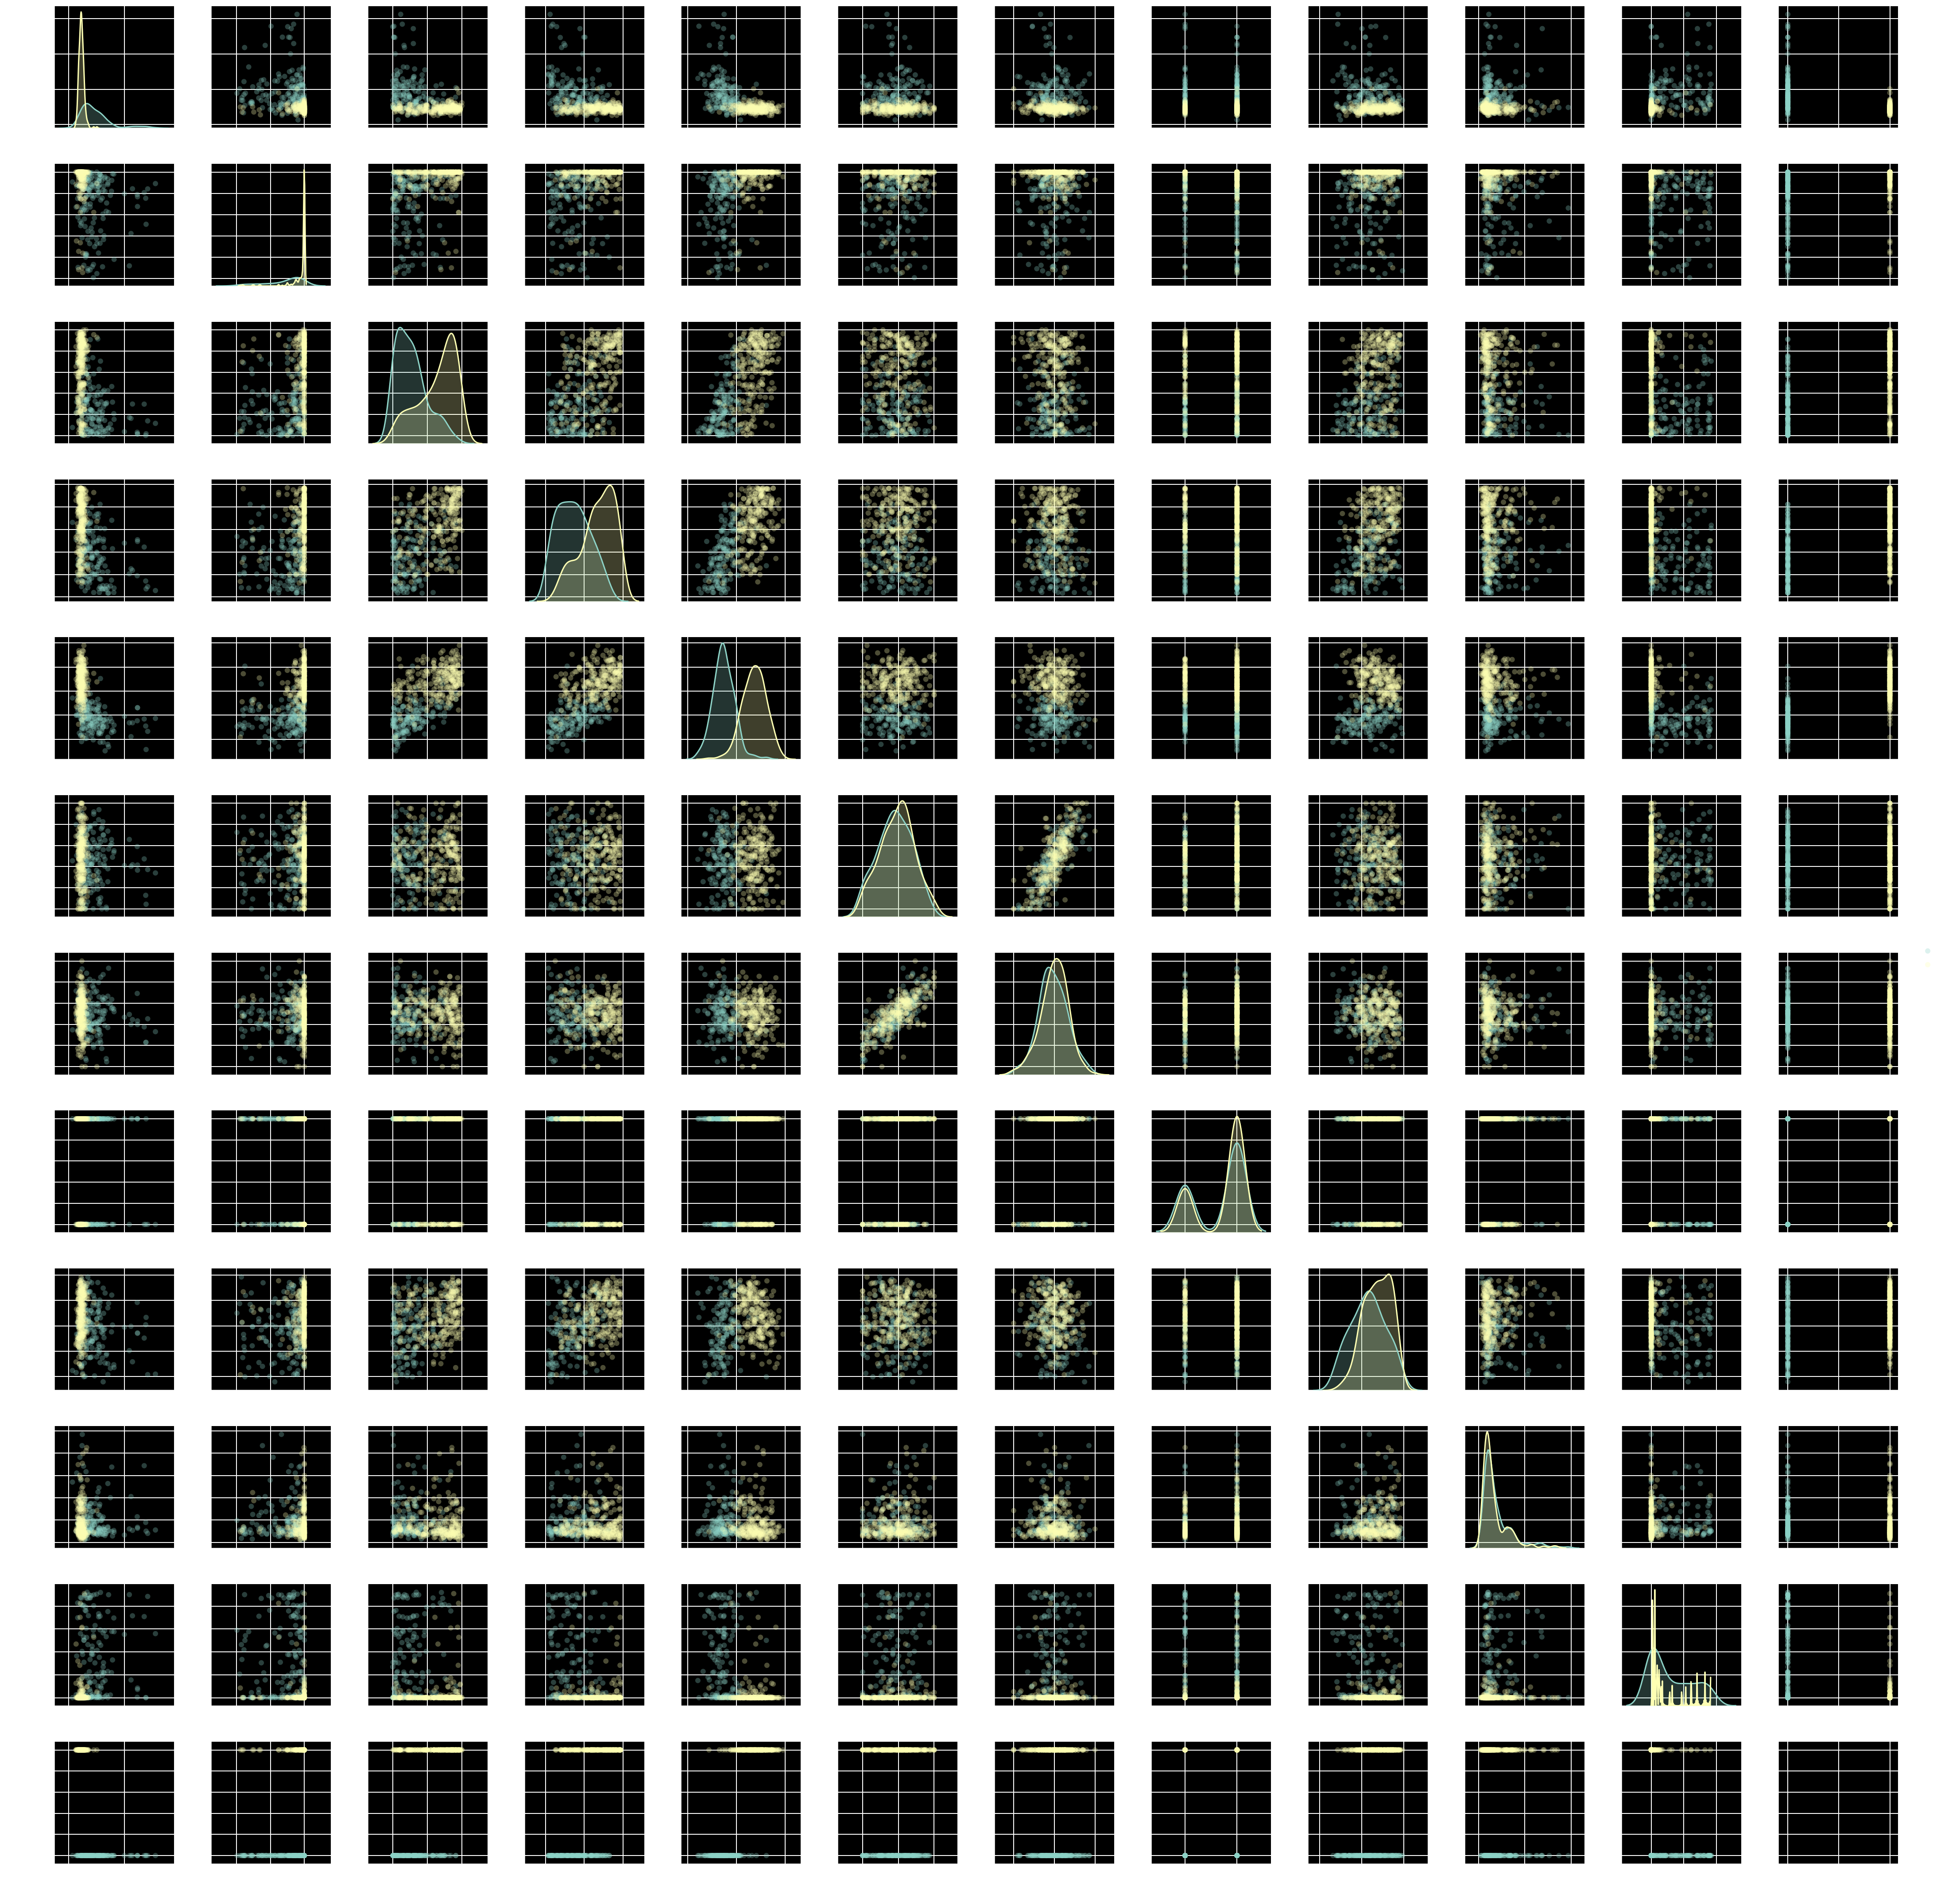

In [8]:
sns.pairplot(df, hue='pop', plot_kws=dict(alpha=.3, edgecolor='none'))

## Complexity Modeling

###  Changes per minute
The total number of key/mode changes plus time signatures per minute
###  Variety
the unique key/modes plus unique time signatures per minute
###  Confidence Penalty
one divided by the time signature confidence plus the tempo confidence with a minimum of one.  This number is then divided by one again.  The result is that low confidences get a score of one and high confidences take a penalty of 2.  This number is the divisor in the complexity score, which penalizes the complexity for high confidence beats.  High beat confidence is associated with pop music.  There are no additional benefits to having extremely low confidence because we don't want to unfairly give music with no drums an advantage.
###  Duration Score
The duration of the song capped at 6.  Longer music is associated with complexity because it has more variations that are not necessarily represented by key changes and key variety.  It's capped at 6 to prevent outliers.

In [9]:
def count_changes(series):
    series = series.reset_index(drop=True)
    return len([i for i in range(1, len(series), 1) if series[i-1] != series[i]])

def get_metrics(df):
    df = df[
        (df.key_confidence > 0.00) &
        (df.mode_confidence > 0.00) &
        (df.time_signature_confidence > 0.00) &
        (df.tempo_confidence > 0.00)
    ]
    df['kmode'] = df['mode'] + df['key']
    df['key_mode_changes'] = df['kmode']
    df['unique_time_signatures'] = df['time_signature']

    df = df.groupby(
            ['artists', 'name'],
            as_index=False
        ).agg({
                     'loudness': 'std', 'tempo':'std',
                     'key_confidence':'std', 'mode_confidence':'std',
                     'unique_time_signatures': 'nunique',
                     'kmode': 'nunique',
                     'key_mode_changes': count_changes,
                     'time_signature': count_changes,
            }
        ).rename(
            columns={
                'loudness': 'loudness_std',
                'tempo': 'tempo_std',
                'key_confidence': 'key_confidence_std',
                'mode_confidence': 'mode_confidence_std',
                'artists': 'artist',
                'kmode': 'key_mode_variety',
                'time_signature': 'time_signature_changes'
            }
    ) 
    return df

def add_cpm(dfs):
    for df in dfs:
        duration = df['duration'] / 60
        df['changes_per_minute'] = (df['key_mode_changes'] + df['time_signature_changes']) / duration
        df['variety'] = (df['unique_time_signatures'] + df['key_mode_variety']) / duration
        df['duration_score'] = duration.apply(lambda x: min(x,6))
        df['confidence_penalty'] = 1 / ( 1 / (
            (df['time_signature_confidence'] + df['tempo_confidence']))
        ).apply(
            lambda x: min(x, 1)
        )
        df['complexity_score'] = (
            df['changes_per_minute'] + df['variety'] + df['duration_score']
        )  / df['confidence_penalty']

df_avant = df_avant.merge(get_metrics(df_avant_sections), on=['artist', 'name'])
df_pop = df_pop.merge(get_metrics(df_pop_sections), on=['artist', 'name'])
add_cpm([df_avant, df_pop])

/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

## Complexity Analysis
Pop music is associated with lower complexity scores thanks to its high beat confidence.  High beat confidence means lower syncopation.  There are also usually fewer key and time changes per minute, however it does quite well given its short duration.

Avant/Rock music is associated with longer durations.  Emerson, Lake, and Palmer's Tarkus is over 20 minutes long, giving it the maximum 6 points for duration, has around double the changes per minute of the average pop song, and has no confidence penalty because of its heavy rhythmic abstraction.

In [30]:
SELECTION = [
    'artist', 'name', 'variety', 'changes_per_minute', 'confidence_penalty', 'duration_score', 'complexity_score'
]

df_pop[SELECTION].sample(10, random_state=25)

artist  \
154               Fox Stevenson   
235             The Cranberries   
66                      Genesis   
228                      Eminem   
223  Pras,Ol' Dirty Bastard,Mýa   
133                    Lykke Li   
4                    Eurythmics   
148              Electric Guest   
97                   Diana Ross   
188                  Your Smith   

                                                  name   variety  \
154                                        Out My Head  0.798297   
235                                             Linger  0.873659   
66                        Invisible Touch - Remastered  1.142132   
228                                         My Name Is  0.892680   
223  Ghetto Supastar (That Is What You Are) - The B...  1.603217   
133            sex money feelings die - slowed version  1.421708   
4         Sweet Dreams (Are Made of This) - Remastered  0.829748   
148                                          Freestyle  0.990099   
97                                      Chain Reaction  2.082128   
188                                    Man Of Weakness  1.243781   

     changes_per_minute  confidence_penalty  duration_score  complexity_score  
154            1.064396               1.393        3.758000          4.034955  
235            1.310489               1.378        4.578445          4.907542  
66             1.142132               1.735        3.502222          3.335151  
228            0.446340               1.310        4.480889          4.442679  
223            1.603217               1.904        4.366222          3.977235  
133            2.132563               1.361        2.813516          4.678756  
4              0.276583               1.860        3.615555          2.538648  
148            0.742574               1.866        4.040000          3.093608  
97             2.862927               1.834        3.842222          4.791318  
188            0.932836               1.668        3.216000          3.232984

In [31]:
df_avant[SELECTION].sample(10, random_state=25)

artist  \
135            Gentle Giant   
26         Sebastian Hardie   
75            Dream Theater   
49   The Edgar Winter Group   
86   Emerson, Lake & Palmer   
21       Coheed and Cambria   
93                  Strawbs   
152           Steve Hackett   
38                  Brand X   
124             Frank Zappa   

                                                  name   variety  \
135                                         Experience  1.020495   
26                                            Openings  0.457116   
75                              On The Backs Of Angels  1.148281   
49                                        Frankenstein  1.899447   
86                                              Tarkus  0.775628   
21                                        Welcome Home  0.960068   
93   Autumn: Heroine's Theme/Deep Summer's Sleep/Th...  0.705753   
152                       The Hermit - Remastered 2005  1.021752   
38                                                 Red  1.160007   
124                             Son Of Mr. Green Genes  0.781599   

     changes_per_minute  confidence_penalty  duration_score  complexity_score  
135            2.040990               1.047        6.000000          8.654713  
26             1.447533               1.301        6.000000          6.075826  
75             2.411391               1.694        6.000000          5.643254  
49             2.110496               1.181        4.738222          7.407422  
86             2.084500               1.000        6.000000          8.860128  
21             0.960068               1.463        6.000000          5.413627  
93             0.941004               1.218        6.000000          6.278126  
152            0.613051               1.000        4.893555          6.528359  
38             1.657153               1.168        6.000000          7.548939  
124            1.786512               1.060        6.000000          8.083123

In [27]:
df_pop['pop'] = 1
df_avant['pop'] = 0
df = pd.concat([df_pop, df_avant])[
    [
        'artist', 'name', 'duration', 'time_signature_confidence', 
        'tempo_confidence', 'valence', 'danceability', 'key_confidence',
        'mode_confidence', 'mode', 'energy', 'liveness', 'instrumentalness',
        'complexity_score', 'pop'
    ]
]

## Distribution of Complexity
Pop music converges to a low complexity score, which seems to match what we already know about the two music groups.  Artists who make eclectic music tend towards higher complexity, although they are known to make simpler music that just has an unusual sound.

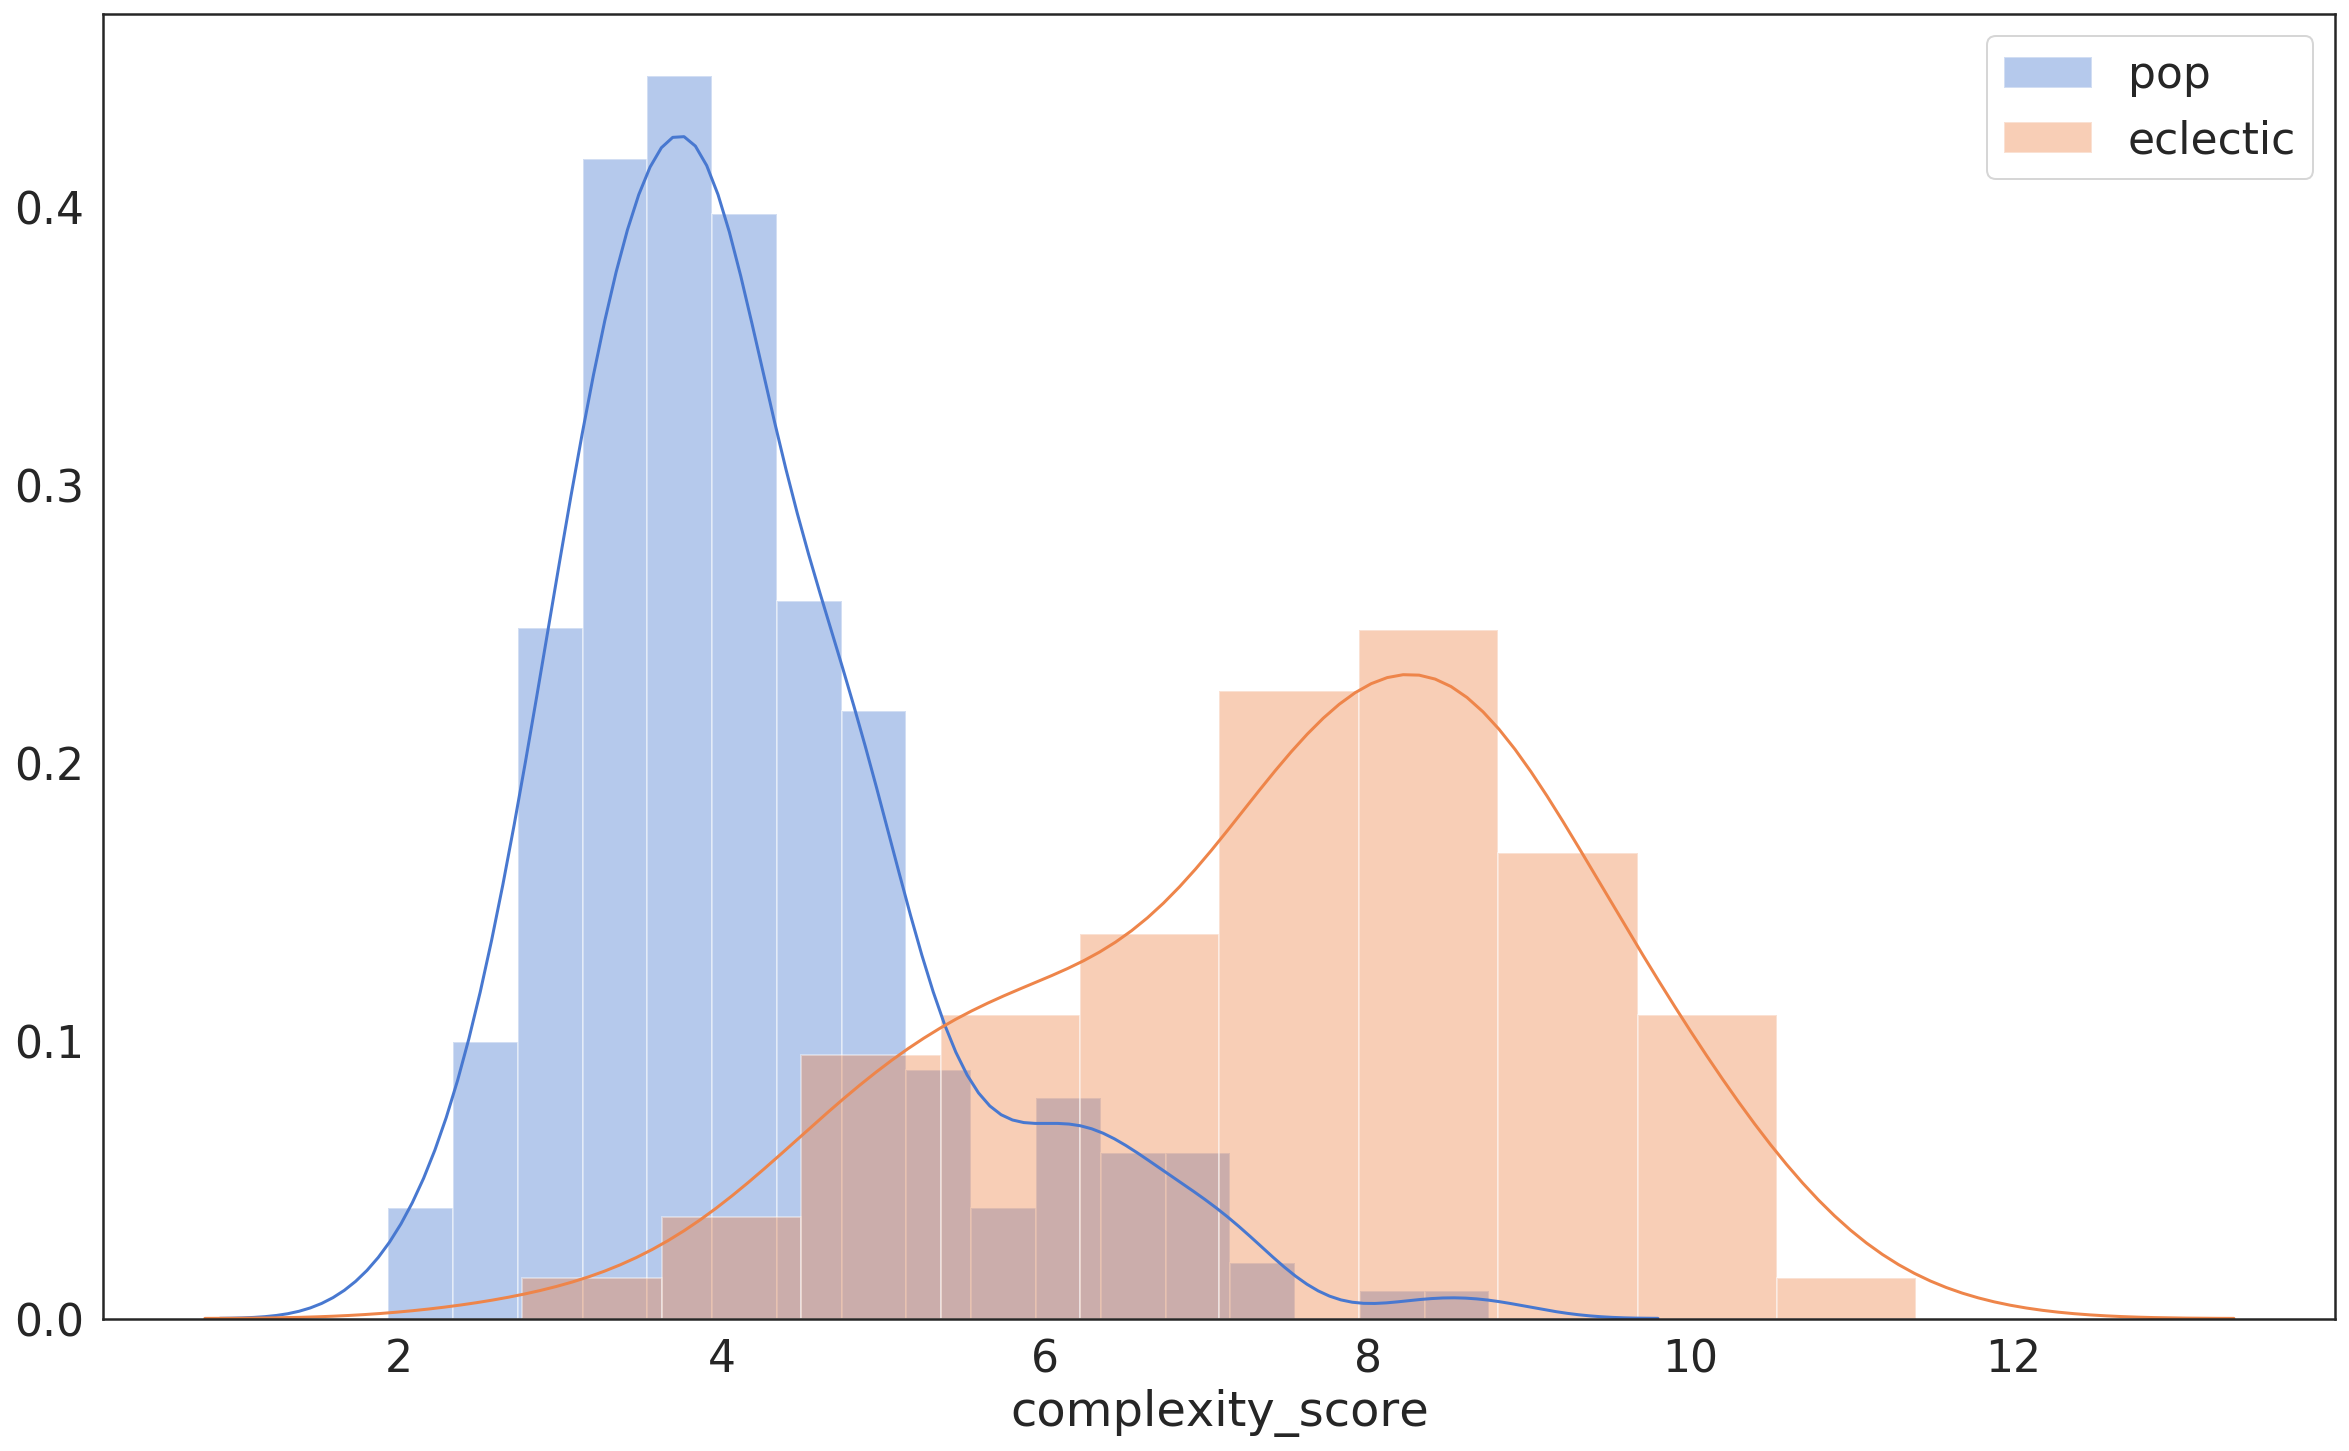

In [28]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
sns.distplot(df[df['pop'] == 1]['complexity_score'], label='pop')
sns.distplot(df[df['pop'] == 0]['complexity_score'], label='eclectic')
ax.legend()

In [ ]:
pop_complexity = df[df['pop'] == 1].complexity_score

from scipy.stats import gaussian_kde
kde = gaussian_kde(pop_complexity)
x = range(len(pop_complexity))
p = kde(range(len(pop_complexity)))
print(p)

## Musical Valence, or Happiness
Spotify analyzes the tonal qualities of the tracks to produce a valence score, which is useful because Pop music tends to sound happier than other music.  This is not always a guarantee, as trends in popular music show that very often sadness can be very marketable

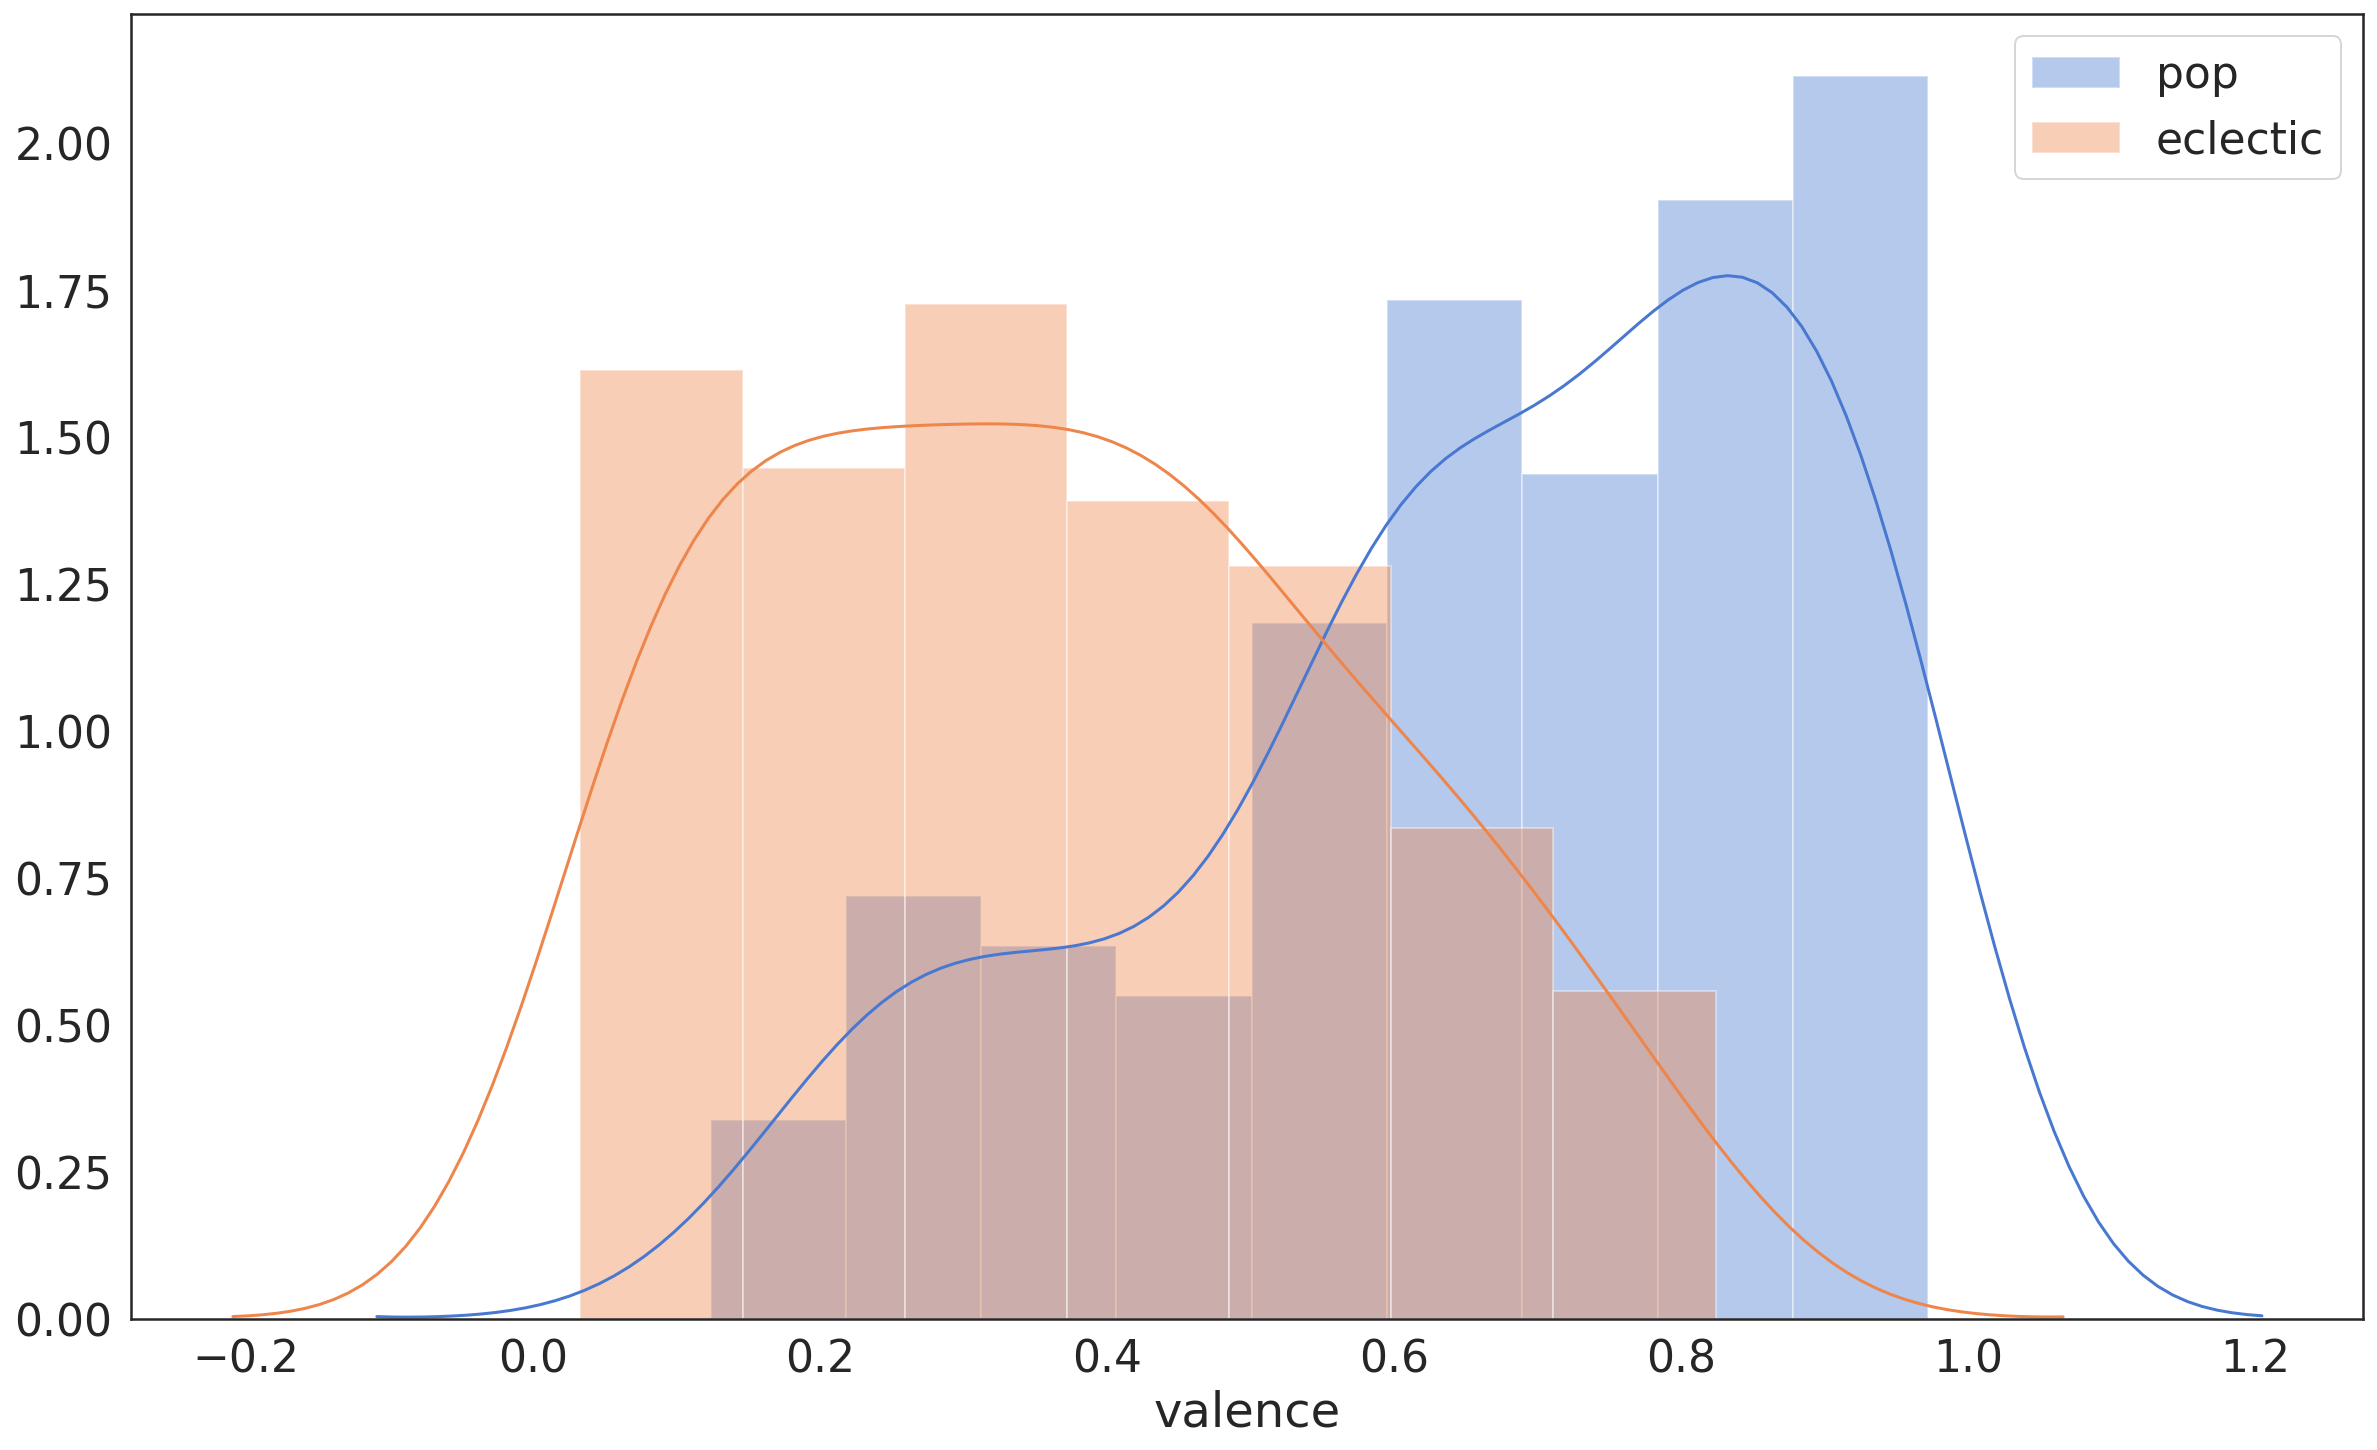

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
sns.distplot(df[df['pop'] == 1]['valence'], label='pop')
sns.distplot(df[df['pop'] == 0]['valence'], label='eclectic')
ax.legend()

## Dancecability
Spotify's Danceability metric clearly shows that, thanks to the higher tempo/time confidencecs, pop music tends to have a stronger beat and more danceability.  If there's less syncopation and abstraction in the music, the dancer is free to fill that space with his movements.  This is the strongest indicator of pop music by far.

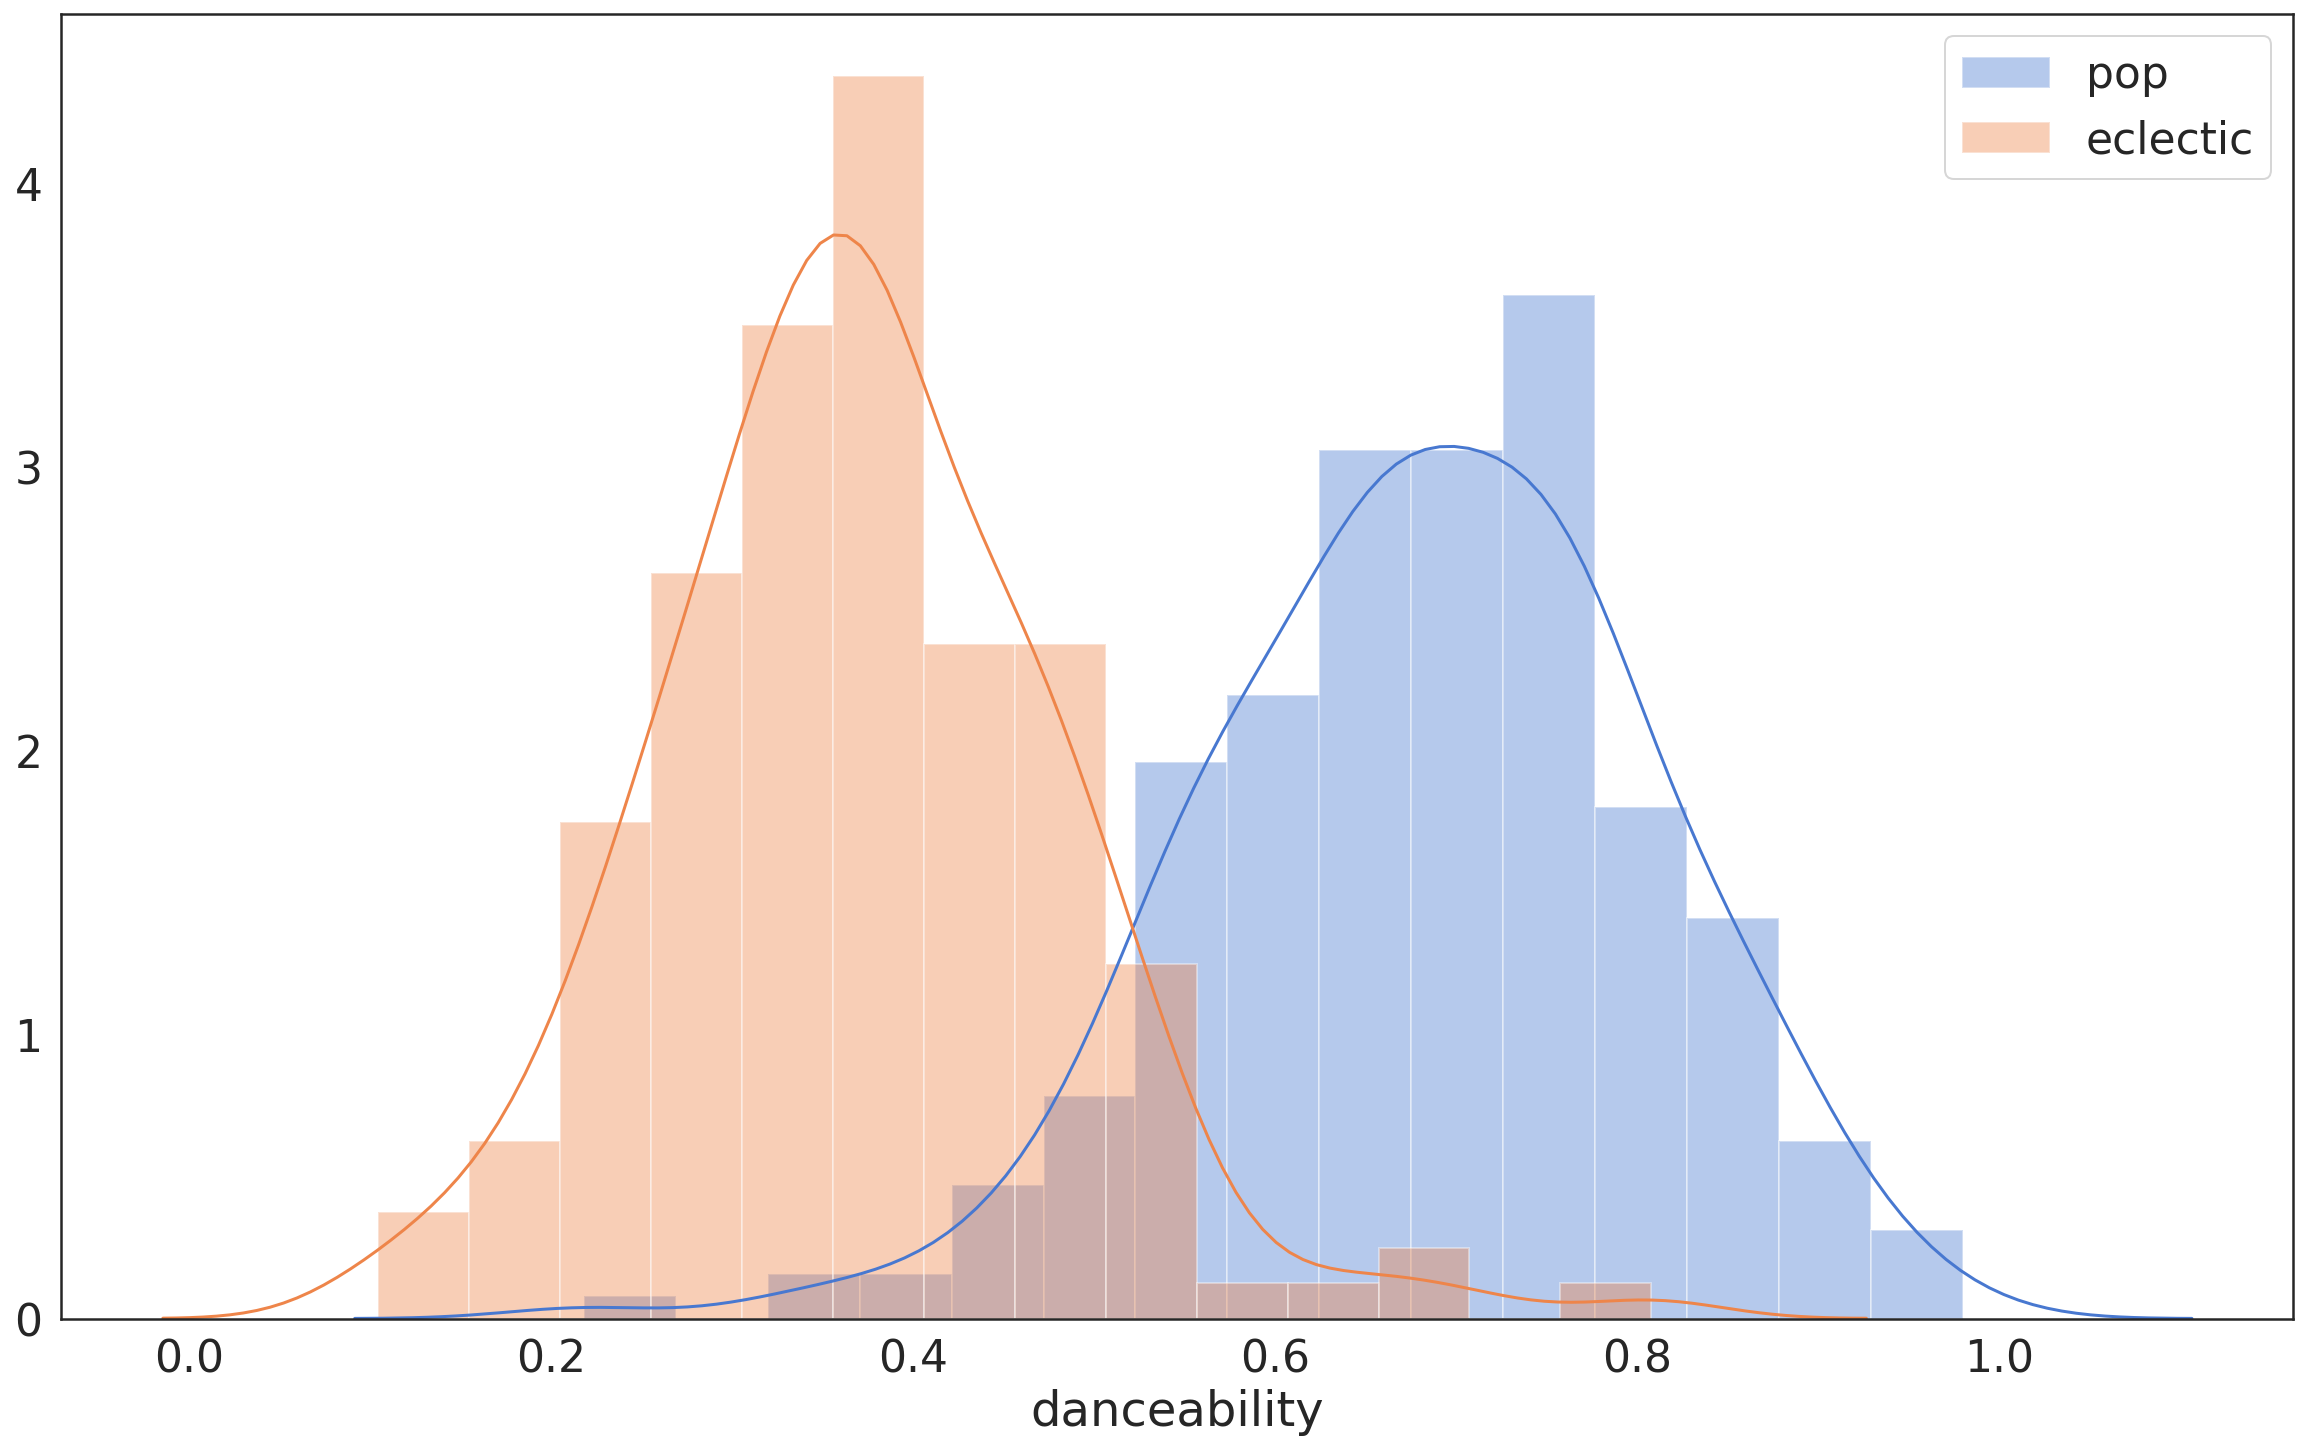

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
sns.distplot(df[df['pop'] == 1]['danceability'], label='pop')
sns.distplot(df[df['pop'] == 0]['danceability'], label='eclectic')
ax.plot(x, norm.pdf(x))

In [56]:
df = pd.concat([df_pop, df_avant])[
    [
        'artist', 'name', 'duration_score', 'valence', 'danceability',
        'variety', 'confidence_penalty', 'changes_per_minute',
        'pop'
    ]
]

In [57]:
df.to_csv('popornot.csv', index=False)